<a href="https://colab.research.google.com/github/matteraggi/maritimeAIS/blob/main/TrainingAIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install + Import**

In [1]:
# === Installazioni necessarie su Colab ===
!pip install pandas numpy pyarrow torch matplotlib scikit-learn

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random, os
from pyproj import Transformer
from google.colab import drive

# **Parametri**

In [2]:
# --- CONFIG ---
DATA_FILE = "ais_preprocessed.parquet"   # percorso nel runtime
SEQUENCE_LEN = 60
DELTA_T = "1min"
FEATURES = ["X","Y","SOG","COG","Heading"]
TARGET_IDX = [0,1]   # colonne X,Y nel FEATURES
TEST_RATIO = 0.15
VAL_RATIO = 0.15
MMSI_SEED = 42
torch.manual_seed(MMSI_SEED)
np.random.seed(MMSI_SEED)
random.seed(MMSI_SEED)

# MODEL HP
INPUT_SIZE = len(FEATURES)
HIDDEN_SIZE = 64
NUM_LAYERS = 1
LR = 1e-3
BATCH_SIZE = 128
EPOCHS = 10
EARLY_STOPPING_PATIENCE = 5

# ATTACK / EVAL
STD_X_M = None   # se calcoli fuori, assegna qui
STD_Y_M = None

# ANOMALIES
ATTACK_ENABLE = True
ATTACK_PROB   = 0.30
DRIFT_METERS  = 500             # se sweep vuoto, usa questo
DRIFT_SWEEP_METERS = [2000, 5000, 10000, 20000]

# **Caricamento dataset**

In [3]:
df = pd.read_parquet(DATA_FILE)
print("Righe totali:", len(df))

transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
STD_X_M = float(xs_m.std()) if STD_X_M is None else STD_X_M
STD_Y_M = float(ys_m.std()) if STD_Y_M is None else STD_Y_M
print(f"STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")

# --- Split per MMSI (meglio che split casuale su righe) ---
# --- Per non mischiare le stesse navi tra train e test ---
mmsi_list = df["MMSI"].unique()
rng = np.random.RandomState(MMSI_SEED)
rng.shuffle(mmsi_list)

n = len(mmsi_list)
n_test = int(TEST_RATIO * n)
n_val  = int(VAL_RATIO * n)

test_mmsi = mmsi_list[:n_test]
val_mmsi  = mmsi_list[n_test:n_test+n_val]
train_mmsi = mmsi_list[n_test+n_val:]

df_train = df[df["MMSI"].isin(train_mmsi)]
df_val   = df[df["MMSI"].isin(val_mmsi)]
df_test  = df[df["MMSI"].isin(test_mmsi)]

print(f"Train navi: {len(train_mmsi)}, Val navi: {len(val_mmsi)}, Test navi: {len(test_mmsi)}")

Righe totali: 185749
STD_X_M=33332.37 m  STD_Y_M=33116.34 m
Train navi: 14, Val navi: 2, Test navi: 2


# **Creazione finestre temporali per train, val e test**

In [4]:
def create_sequences(df, seq_len=SEQUENCE_LEN, features=FEATURES):
    Xs, ys = [], []
    for mmsi, group in df.groupby("MMSI"):
        group = group.sort_values("BaseDateTime")
        data = group[features].values
        for i in range(len(data) - seq_len):
            Xs.append(data[i:i+seq_len])
            ys.append(data[i+seq_len, :2])  # prevedi solo X,Y
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(df_train)
X_val,   y_val   = create_sequences(df_val)
X_test,  y_test  = create_sequences(df_test)

print(f"Train: {len(X_train)}  Val: {len(X_val)}  Test: {len(X_test)}")

Train: 150349  Val: 12840  Test: 21480


# **LSTM model (Long Short Term Memory)**

In [5]:
class TrajectoryLSTM(nn.Module):
    def __init__(self, input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = TrajectoryLSTM()
criterion = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# **Mount Drive**

In [7]:
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


# **Training**

In [8]:
def to_tensor(a):
    return torch.tensor(a, dtype=torch.float32)

X_train_t, y_train_t = to_tensor(X_train), to_tensor(y_train)
X_val_t, y_val_t = to_tensor(X_val), to_tensor(y_val)

best_val = float('inf')
patience = 0

for epoch in range(EPOCHS):
    model.train()
    idx = torch.randperm(len(X_train_t))
    for i in range(0, len(X_train_t), BATCH_SIZE):
        batch_idx = idx[i:i+BATCH_SIZE]
        Xb, yb = X_train_t[batch_idx], y_train_t[batch_idx]

        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    # --- validazione ---
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_t)
        val_loss = criterion(val_pred, y_val_t).item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")

    # early stopping
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        patience = 0
    else:
        patience += 1
        if patience >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered")
            break

# === salva anche su Google Drive ===
!cp best_model.pt "/content/drive/MyDrive/best_model.pt"
print("✅ Modello salvato su Drive come 'best_model.pt'")

Epoch 1/10 | Train loss: 0.000050 | Val loss: 0.000100
Epoch 2/10 | Train loss: 0.000025 | Val loss: 0.000040
Epoch 3/10 | Train loss: 0.000013 | Val loss: 0.000027
Epoch 4/10 | Train loss: 0.000012 | Val loss: 0.000033
Epoch 5/10 | Train loss: 0.000013 | Val loss: 0.000037
Epoch 6/10 | Train loss: 0.000014 | Val loss: 0.000022
Epoch 7/10 | Train loss: 0.000012 | Val loss: 0.000024
Epoch 8/10 | Train loss: 0.000004 | Val loss: 0.000010
Epoch 9/10 | Train loss: 0.000009 | Val loss: 0.000014
Epoch 10/10 | Train loss: 0.000004 | Val loss: 0.000008
✅ Modello salvato su Drive come 'best_model.pt'


# **Caricare modello**

In [ ]:
drive.mount('/content/drive')

!cp "/content/drive/MyDrive/best_model.pt" .

model = TrajectoryLSTM(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, output_size=2)
model.load_state_dict(torch.load("best_model.pt", map_location="cpu"))
model.eval()

print("✅ Modello caricato da Drive e pronto per inferenza/anomaly detection")

# **Creazione anomalie (spoofing simulato)**

In [9]:
def simulate_silent_drift(X, std_x_m, meters, prob=0.3, axis=0, rng=None):
    rng = rng or np.random.RandomState(42)
    drift_z_total = meters / std_x_m
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)

    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i]
            steps = np.linspace(0, drift_z_total, seq.shape[0])
            seq[:, axis] += steps  # drift crescente
            X_att[i] = seq
            labels[i] = 1
    return X_att, labels


def simulate_kinematic_attack(X, std_x_m, meters, prob=0.3, rng=None):
    rng = rng or np.random.RandomState(42)
    drift_z = meters / std_x_m
    X_att = X.copy()
    N = len(X)
    labels = np.zeros(N)
    for i in range(N):
        if rng.rand() < prob:
            seq = X_att[i]
            seq[:,0] += drift_z  # cambia X
            # NON cambia COG o SOG -> incoerenza fisica
            X_att[i] = seq
            labels[i] = 1
    return X_att, labels



# **Valutazione e visualizzazione**

DEBUG STD: 33332.365630895016 33116.342012071436
Errore medio in metri: clean=855.72 m, attack=1405.05 m


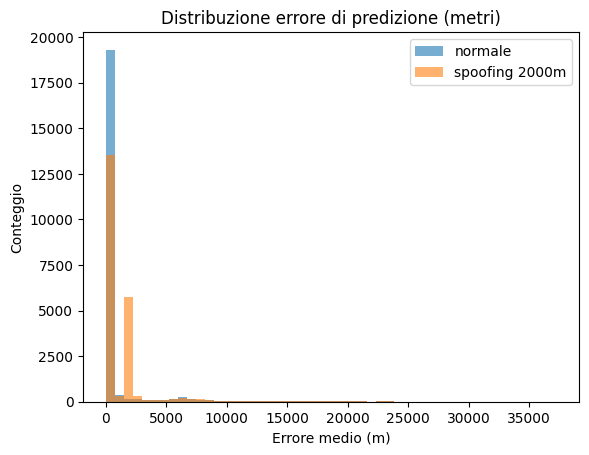

Errore medio (clean=0.00507, attack=0.00580) σ_clean=0.03532 σ_attack=0.03571
Drift 2000 m → AUROC=0.928  AUPRC=0.490  TPR@99p=1.0%
Errore medio in metri: clean=855.72 m, attack=2270.27 m


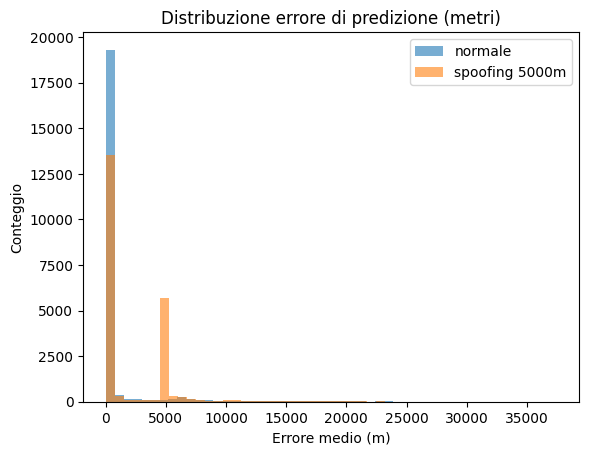

Errore medio (clean=0.00507, attack=0.00882) σ_clean=0.03532 σ_attack=0.03658
Drift 5000 m → AUROC=0.947  AUPRC=0.560  TPR@99p=1.0%
Errore medio in metri: clean=855.72 m, attack=3717.06 m


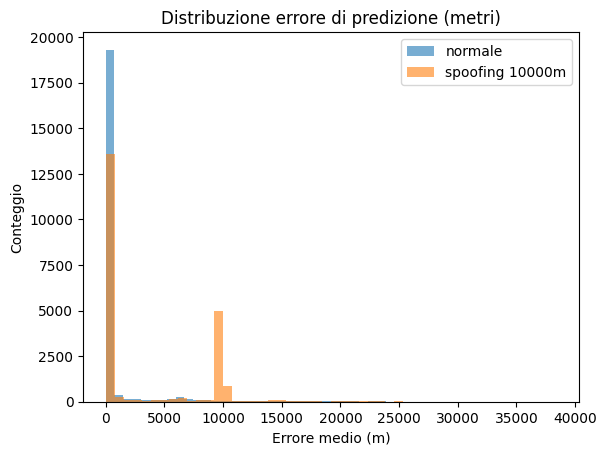

Errore medio (clean=0.00507, attack=0.01899) σ_clean=0.03532 σ_attack=0.04225
Drift 10000 m → AUROC=0.980  AUPRC=0.742  TPR@99p=1.1%
Errore medio in metri: clean=855.72 m, attack=6617.46 m


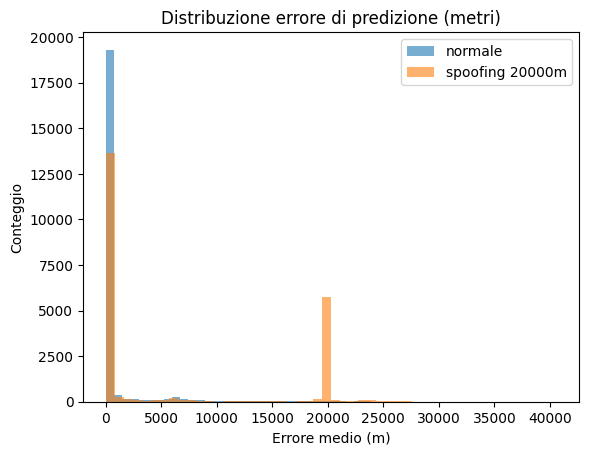

Errore medio (clean=0.00507, attack=0.05862) σ_clean=0.03532 σ_attack=0.08968
Drift 20000 m → AUROC=0.991  AUPRC=0.858  TPR@99p=30.3%

[Risultati sweep]
 2000 m  AUROC=0.928  AUPRC=0.490  TPR@99p=1.0%
 5000 m  AUROC=0.947  AUPRC=0.560  TPR@99p=1.0%
10000 m  AUROC=0.980  AUPRC=0.742  TPR@99p=1.1%
20000 m  AUROC=0.991  AUPRC=0.858  TPR@99p=30.3%


In [10]:
# Predizioni su test pulito
def to_tensor(a): return torch.tensor(a, dtype=torch.float32)
X_test_t = to_tensor(X_test)
model.eval()
with torch.no_grad():
    pred_clean = model(X_test_t).numpy()
err_clean = np.mean((pred_clean - y_test)**2, axis=1)

from sklearn.metrics import roc_auc_score, average_precision_score

def eval_attack(drift_m):
    # --- genera dati attaccati ---
    X_attack, labels = simulate_silent_drift(
        X_test, std_x_m=STD_X_M, meters=drift_m, prob=ATTACK_PROB
    )

    # --- predizione ---
    with torch.no_grad():
        pred_att = model(to_tensor(X_attack)).numpy()

    # --- errori normalizzati ---
    err_att = np.mean((pred_att - y_test)**2, axis=1)

    # --- errori in metri ---
    err_clean_m = np.sqrt(((pred_clean - y_test)**2).sum(axis=1)) * STD_X_M
    err_att_m   = np.sqrt(((pred_att   - y_test)**2).sum(axis=1)) * STD_X_M

    print(f"Errore medio in metri: clean={err_clean_m.mean():.2f} m, attack={err_att_m.mean():.2f} m")

    # --- metriche di detection ---
    labels_all = np.concatenate([np.zeros_like(err_clean), labels])
    scores_all = np.concatenate([err_clean, err_att])
    auc  = roc_auc_score(labels_all, scores_all)
    aupr = average_precision_score(labels_all, scores_all)

    # --- grafico in metri ---
    plt.hist(err_clean_m, bins=50, alpha=0.6, label='normale')
    plt.hist(err_att_m,   bins=50, alpha=0.6, label=f'spoofing {drift_m}m')
    plt.title("Distribuzione errore di predizione (metri)")
    plt.xlabel("Errore medio (m)")
    plt.ylabel("Conteggio")
    plt.legend()
    plt.show()

    # --- soglia e detection rate ---
    thr = np.percentile(err_clean, 99)
    tpr = float(np.mean(err_att > thr))

    print(f"Errore medio (clean={err_clean.mean():.5f}, attack={err_att.mean():.5f}) "
          f"σ_clean={err_clean.std():.5f} σ_attack={err_att.std():.5f}")
    print(f"Drift {drift_m} m → AUROC={auc:.3f}  AUPRC={aupr:.3f}  TPR@99p={tpr*100:.1f}%")

    return auc, aupr, tpr

# --- Controllo STD ---
if STD_X_M is None:
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:32616", always_xy=True)
    xs_m, ys_m = transformer.transform(df["LON"].values, df["LAT"].values)
    STD_X_M = float(xs_m.std())
    STD_Y_M = float(ys_m.std())
    print(f"[Auto-calibrato] STD_X_M={STD_X_M:.2f} m  STD_Y_M={STD_Y_M:.2f} m")
print("DEBUG STD:", STD_X_M, STD_Y_M)
if ATTACK_ENABLE:
    if DRIFT_SWEEP_METERS:
        results = []
        for d in DRIFT_SWEEP_METERS:
            results.append((d, *eval_attack(d)))
        # tabellina risultati
        print("\n[Risultati sweep]")
        for d, auc, aupr, tpr in results:
            print(f"{d:>5} m  AUROC={auc:.3f}  AUPRC={aupr:.3f}  TPR@99p={tpr*100:.1f}%")
    else:
        eval_attack(DRIFT_METERS)

**Output atteso**

Grafico MSE: la curva “spoofing” sarà spostata a destra → errore maggiore.

Tasso rilevamento: >90% con drift marcato.